In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

#models
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
#from catboost import CatBoostClassifier

#metrics
import sklearn.metrics as metrics

#hiperparameters
from sklearn.model_selection import GridSearchCV

In [1]:
from catboost import CatBoostClassifier

## Load clean data

In [3]:
df = pd.read_csv('./EDA/clean_train_test.csv')
df.head(1)

,mou,totmrc,vceovr,datovr,roam,change_mou,change_rev,drop_vce,blck_vce,unan_vce,...,prizm_social_one_U,dualband_N,dualband_T,dualband_Y,marital_A,marital_B,marital_M,marital_S,marital_U,dualband_U
0,219.25,22.5,0.0,0.0,0.0,-157.25,-18.9975,0.666667,0.666667,6.333333,...,0,0,0,1,0,0,0,1,0,0


In [4]:
df_id_customer_train = df['Customer_ID']
#df_id_customer_predicr = df_predecir2['Customer_ID']

del(df['Customer_ID'])
#del(df_predecir2['Customer_ID'])

## I do a RandomForest to see which variables are more correlated

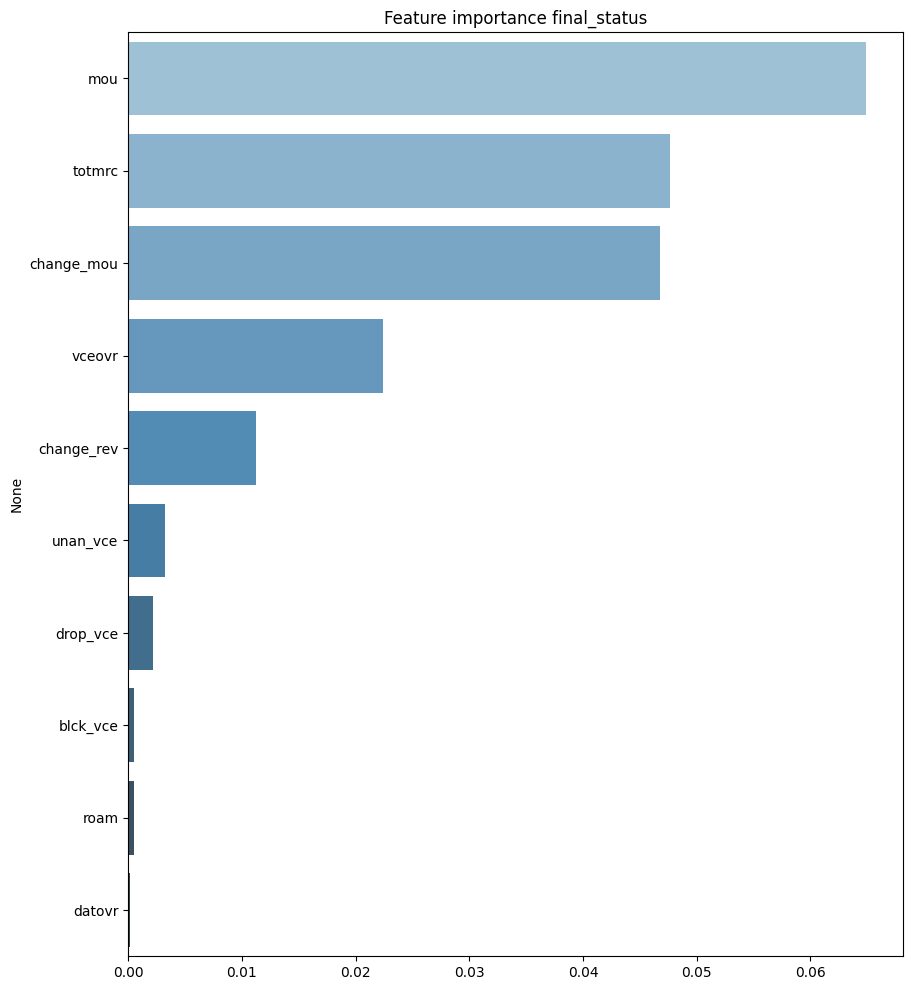

In [5]:
params = {'random_state': 42, 'n_jobs': 4, 'n_estimators': 100, 'max_depth': 4}

x, y = df.drop('churn',axis=1), df['churn']
# entrena un RandomForest Classifier
clf = RandomForestClassifier(**params)
clf = clf.fit(x, y)
# Plotea las 10 mejores Features importances
features = clf.feature_importances_[:10]
columnas = x.columns[:10]
imp = pd.Series(data=features, index=columnas).sort_values(ascending=False)
plt.figure(figsize=(10,12))
plt.title("Feature importance {}".format('final_status'))
ax = sns.barplot(y=imp.index, x=imp.values, palette="Blues_d", orient='h')
plt.show()

## Split X-y

In [6]:
# se guarda la target como y y las features como X
y = df['churn']
X = df.drop('churn', axis=1)

# se guarda un 30% de datos para el test y un 70% para el train con train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Distribution of Target

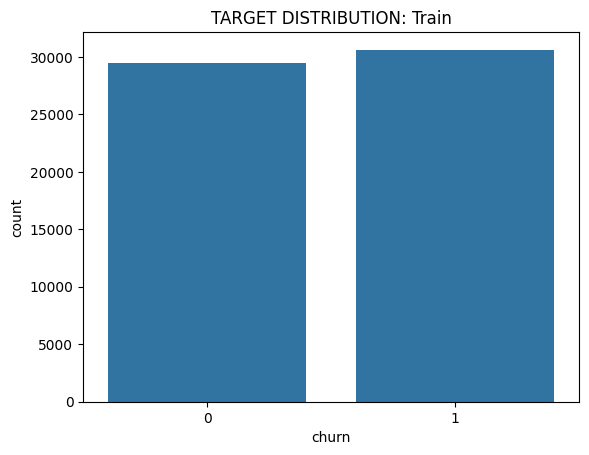

In [7]:
sns.countplot(x=y_train)
plt.title('TARGET DISTRIBUTION: Train')
plt.show()

In [8]:
# I´m going to standarize the variables with StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)   
X_test = scaler.transform(X_test)

## TRAIN -VALIDA

### Model Tournament

In [9]:
def medicion(y_t, y_p):
  """Print the  ROC and the AUC curve"""

  # calculate the fpr and tpr for all thresholds of the classification
  fpr, tpr, threshold = metrics.roc_curve(y_t, y_p)
  roc_auc = metrics.auc(fpr, tpr)

  # para añadir el gráfico
  # method I: plt
  import matplotlib.pyplot as plt
  plt.figure(figsize=(8, 6))
  plt.title('Receiver Operating Characteristic')
  plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
  plt.legend(loc = 'lower right')
  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([0, 1])
  plt.ylim([0, 1])
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.show()
  return roc_auc

In [10]:
def entrenar(Xtrain, Xtest, ytrain, ytest):
  """entrena 6 módelos.
      imprime la curva roc de cada módelo junto al valor AUC
      devuelve un dataframe con los valores de AUC redondeados a 5 decimales para cada módelo"""

  # creamos la lista de auc vacía
  lista_aucs = []

  # Support Vector Machine
  print('Support Vector Machine')
  svclassifier = SVC(max_iter=20)

  svclassifier.fit(Xtrain, ytrain)
  y_pred = svclassifier.predict(Xtest)

  roc_auc = medicion(ytest, y_pred)
  lista_aucs.append(('SVC', round(roc_auc, 5)))

  # Regresión logística
  print('Regresión logística')
  lr = LogisticRegression(max_iter=40)

  lr.fit(Xtrain, ytrain)
  y_pred = lr.predict(Xtest)

  roc_auc = medicion(ytest, y_pred)
  lista_aucs.append(('regresión logística', round(roc_auc, 5)))

  # RidgeClassifier
  print('RidgeClassifier')
  rc = RidgeClassifier(max_iter=40)

  rc.fit(Xtrain, ytrain)
  y_pred = rc.predict(Xtest)

  roc_auc = medicion(ytest, y_pred)
  lista_aucs.append(('RidgeClassifier', round(roc_auc, 5)))

  # Decision tree classsifier
  print('Decision tree classsifier')
  dt_base = DecisionTreeClassifier(random_state=42)

  dt_base.fit(Xtrain, ytrain)
  y_pred = dt_base.predict(Xtest)

  roc_auc = medicion(ytest, y_pred)
  lista_aucs.append(('decision tree classifier', round(roc_auc, 5)))

  # Random forest
  print('Random forest')
  rf_base = RandomForestClassifier(random_state=42)

  rf_base.fit(Xtrain, ytrain)
  y_pred = rf_base.predict(Xtest)

  roc_auc = medicion(ytest, y_pred)
  lista_aucs.append(('random forest', round(roc_auc, 5)))

  # Gradient boosting
  print('Gradient boosting')
  gbc_base = GradientBoostingClassifier(random_state=42)

  gbc_base.fit(Xtrain, ytrain)
  y_pred = gbc_base.predict(Xtest)

  roc_auc = medicion(ytest, y_pred)
  lista_aucs.append(('gradient boosting', round(roc_auc, 5)))

  # XGBClassifier
  print('XGBClassifier')
  xgbc_base = XGBClassifier(random_state=42)

  xgbc_base.fit(Xtrain, ytrain)
  y_pred = xgbc_base.predict(Xtest)

  roc_auc = medicion(ytest, y_pred)
  lista_aucs.append(('XGB classifier', round(roc_auc, 5)))

  # CatBoostClassifier
  print('CatBoostClassifier')
  cat_base = CatBoostClassifier(verbose=False, random_state=42)

  cat_base.fit(Xtrain, ytrain)
  y_pred = cat_base.predict(Xtest)

  roc_auc = medicion(ytest, y_pred)
  lista_aucs.append(('CatBoost Classifier', round(roc_auc, 5)))

  df_aucs = pd.DataFrame(lista_aucs, columns=['modelos', 'AUC'])
  df_aucs = df_aucs.set_index('modelos')

  return df_aucs

Support Vector Machine


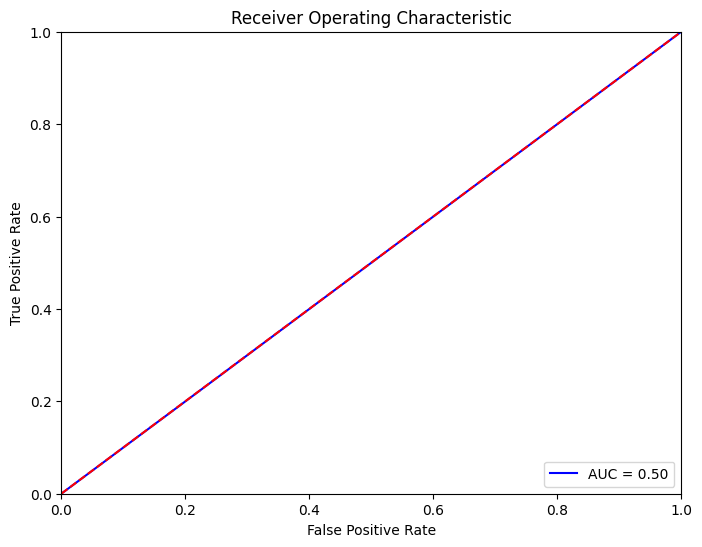

Regresión logística


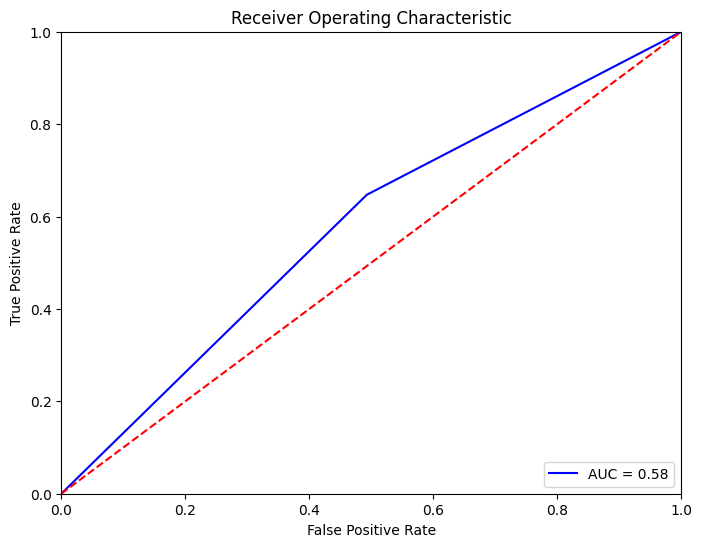

RidgeClassifier


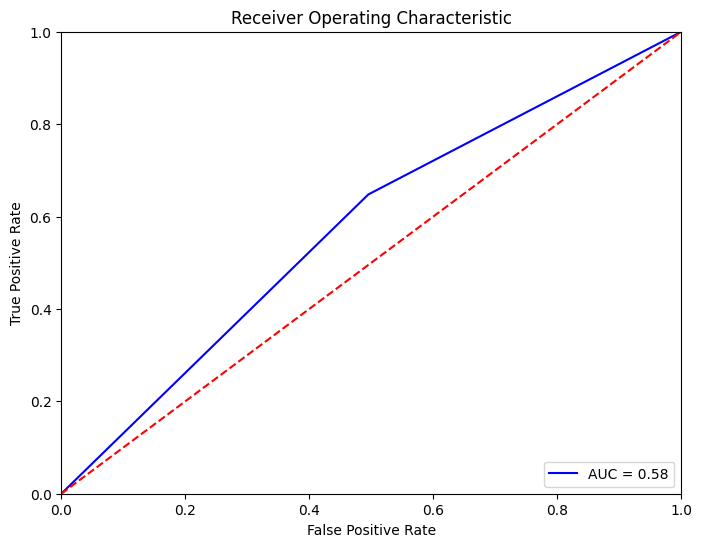

Decision tree classsifier


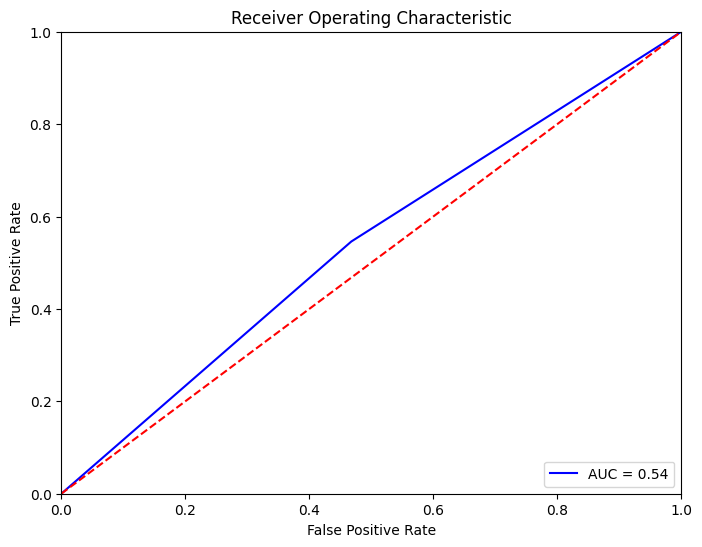

Random forest


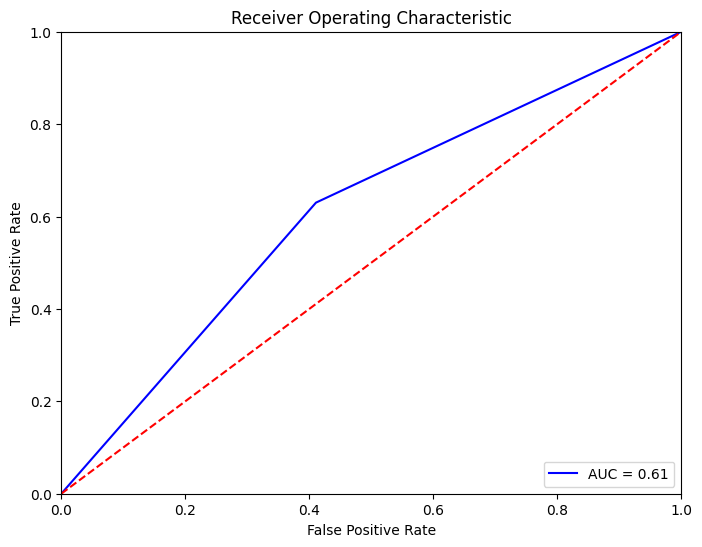

Gradient boosting


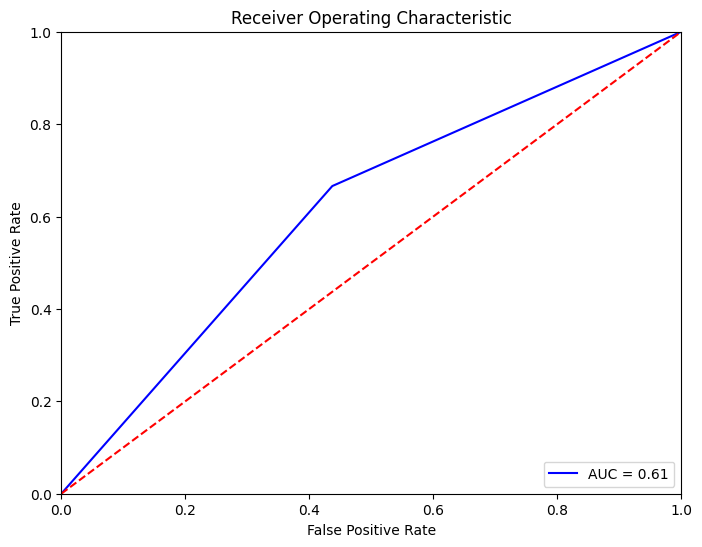

XGBClassifier


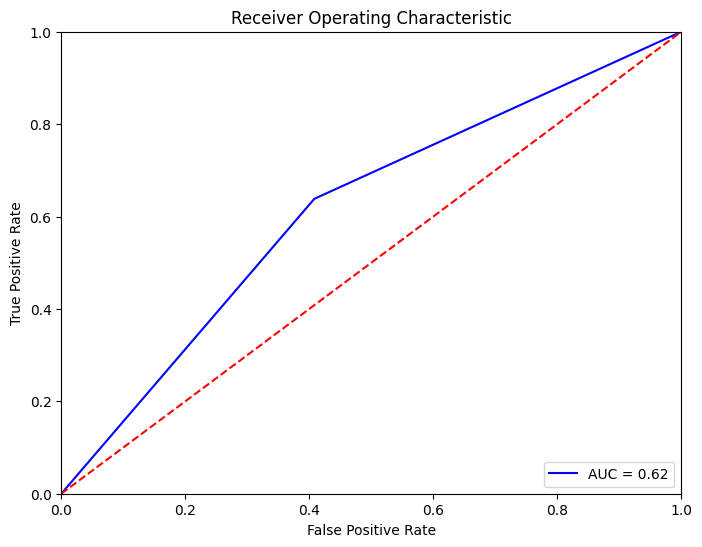

CatBoostClassifier


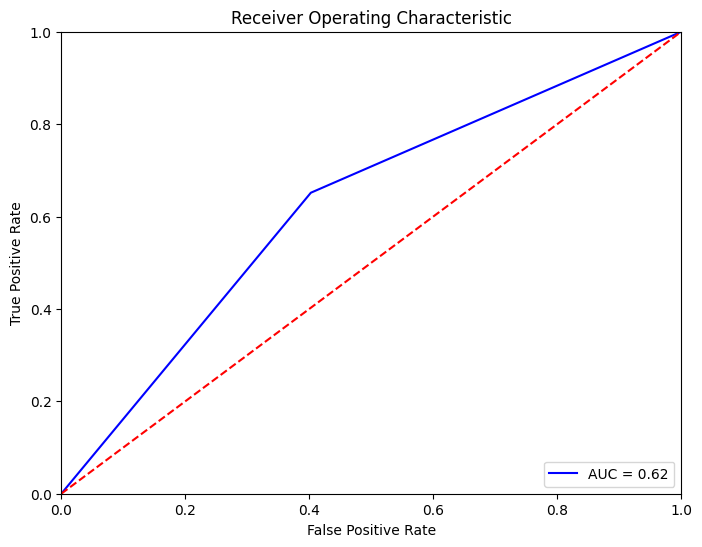

In [11]:
aucs = entrenar(X_train, X_test, y_train, y_test)

In [12]:
aucs

,AUC
modelos,
SVC,0.49988
regresión logística,0.57715
RidgeClassifier,0.57626
decision tree classifier,0.53905
random forest,0.60964
gradient boosting,0.61441
XGB classifier,0.61509
CatBoost Classifier,0.62448


In [13]:
model = CatBoostClassifier()

## Hiperparameters

In [14]:
parameters = {
    'iterations': [100, 200],
    'learning_rate': [0.03,0,1],
    'depth': [4, 6, 10]
              }

In [15]:
modelo_grid = GridSearchCV(model,
                        parameters,
                        cv=2,
                        verbose=True)

modelo_grid.fit(X_train, y_train)

Fitting 2 folds for each of 18 candidates, totalling 36 fits
0:	learn: 0.6923233	total: 53.5ms	remaining: 5.3s
1:	learn: 0.6913071	total: 94.3ms	remaining: 4.62s
2:	learn: 0.6902229	total: 141ms	remaining: 4.57s
3:	learn: 0.6894284	total: 157ms	remaining: 3.77s
4:	learn: 0.6886634	total: 179ms	remaining: 3.41s
5:	learn: 0.6877535	total: 195ms	remaining: 3.06s
6:	learn: 0.6870852	total: 216ms	remaining: 2.87s
7:	learn: 0.6863213	total: 237ms	remaining: 2.73s
8:	learn: 0.6856500	total: 254ms	remaining: 2.57s
9:	learn: 0.6850291	total: 273ms	remaining: 2.46s
10:	learn: 0.6845487	total: 290ms	remaining: 2.34s
11:	learn: 0.6839821	total: 316ms	remaining: 2.31s
12:	learn: 0.6833195	total: 342ms	remaining: 2.29s
13:	learn: 0.6827176	total: 384ms	remaining: 2.36s
14:	learn: 0.6821772	total: 402ms	remaining: 2.28s
15:	learn: 0.6816466	total: 439ms	remaining: 2.31s
16:	learn: 0.6812415	total: 466ms	remaining: 2.27s
17:	learn: 0.6806321	total: 514ms	remaining: 2.34s
18:	learn: 0.6801478	total: 53

GridSearchCV(cv=2,
             estimator=<catboost.core.CatBoostClassifier object at 0x7fa2a949ac50>,
             param_grid={'depth': [4, 6, 10], 'iterations': [100, 200],
                         'learning_rate': [0.03, 0, 1]},
             verbose=True)

In [16]:
#print best parameters
modelo_grid.best_params_

{'depth': 10, 'iterations': 200, 'learning_rate': 0.03}

## Final Model

In [17]:
model = CatBoostClassifier(depth= 6, iterations= 200, learning_rate=0.1)

In [18]:
model.fit(X_train, y_train) # entrena mi modelo elegido con los datos de Train
y_pred_test = model.predict(X_test)

0:	learn: 0.6889022	total: 20.4ms	remaining: 4.05s
1:	learn: 0.6859945	total: 47.3ms	remaining: 4.68s
2:	learn: 0.6830759	total: 74ms	remaining: 4.86s
3:	learn: 0.6804968	total: 104ms	remaining: 5.07s
4:	learn: 0.6780805	total: 128ms	remaining: 5.01s
5:	learn: 0.6755686	total: 169ms	remaining: 5.47s
6:	learn: 0.6735131	total: 229ms	remaining: 6.3s
7:	learn: 0.6719060	total: 293ms	remaining: 7.03s
8:	learn: 0.6706403	total: 317ms	remaining: 6.74s
9:	learn: 0.6694405	total: 337ms	remaining: 6.4s
10:	learn: 0.6683644	total: 359ms	remaining: 6.17s
11:	learn: 0.6673294	total: 380ms	remaining: 5.95s
12:	learn: 0.6664705	total: 396ms	remaining: 5.7s
13:	learn: 0.6655226	total: 411ms	remaining: 5.46s
14:	learn: 0.6645921	total: 426ms	remaining: 5.25s
15:	learn: 0.6635439	total: 450ms	remaining: 5.17s
16:	learn: 0.6628758	total: 473ms	remaining: 5.09s
17:	learn: 0.6620438	total: 501ms	remaining: 5.07s
18:	learn: 0.6611720	total: 524ms	remaining: 4.99s
19:	learn: 0.6605962	total: 563ms	remaining

In [19]:
model.predict_proba(X_test)[:,1]

array([0.55311425, 0.56885364, 0.58392179, ..., 0.49473089, 0.45829658,
       0.63511786])

### I created a dataframe with my results of test

In [20]:
df_values = pd.DataFrame()

In [21]:
df_values['target_real']=y_test
df_values['prediccion']=y_pred_test
df_values['prediccion_proba']=model.predict_proba(X_test)[:,1]

In [ ]:
df_values

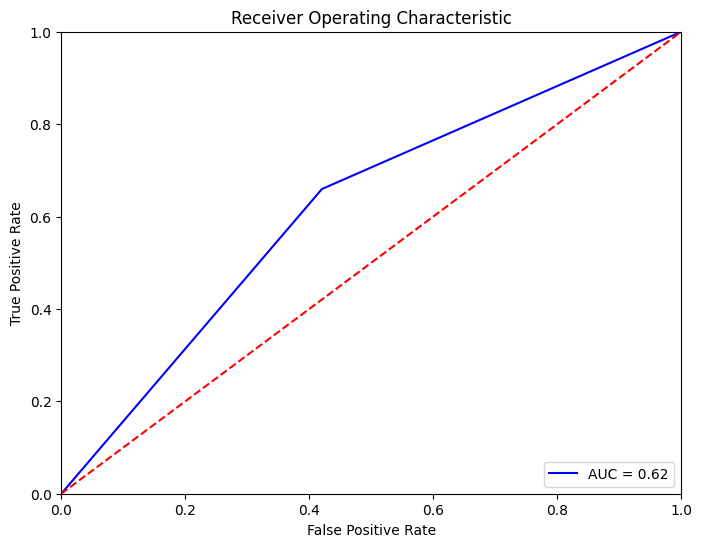

0.6195686003894604


In [22]:
roc_auc = medicion(y_test, y_pred_test)
print(roc_auc)

## Test

In [23]:
y_train_pred = model.predict(X_train)                        
y_test_pred = model.predict(X_test)

In [24]:
y_train_pred_proba = model.predict_proba(X_train)[:, 1]      
y_test_pred_proba = model.predict_proba(X_test)[:, 1]

In [25]:
from sklearn.metrics import roc_auc_score

In [26]:
auc_train = roc_auc_score(y_train, y_train_pred_proba)
auc_test = roc_auc_score(y_test, y_test_pred_proba)   

In [27]:
print('AUC Train:', round(auc_train,4))
print('AUC Test:', round(auc_test,4))

AUC Train: 0.7257
AUC Test: 0.6707


### ROC curve

In [28]:
from sklearn.metrics import roc_curve

In [29]:
# metrics for ROC
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred_proba)

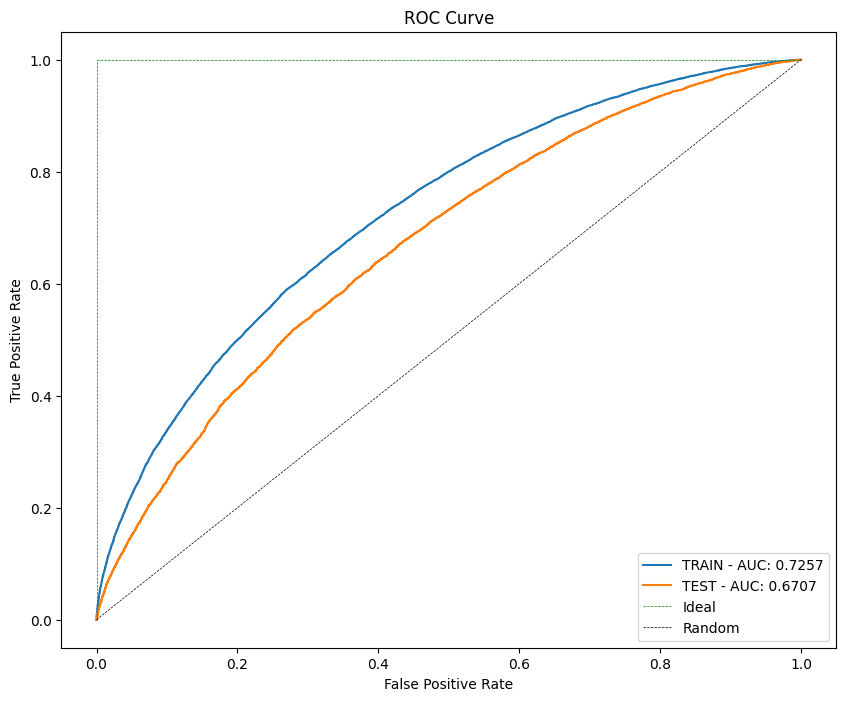

In [30]:
#Plot
plt.figure(figsize=[10,8])
plt.plot(fpr_train, tpr_train, label='TRAIN - AUC: {:.4f}'.format(auc_train))
plt.plot(fpr_test, tpr_test, label='TEST - AUC: {:.4f}'.format(auc_test))
plt.title('ROC Curve')
plt.plot([0,0,1],[0,1,1], color='green', linestyle='--', linewidth=0.5, label='Ideal')
plt.plot([0, 1], [0, 1], color='black', linestyle='--', linewidth=0.5, label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

### Matrix Confusion

In [31]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [32]:
cm_test = confusion_matrix(y_test, y_test_pred)

[]

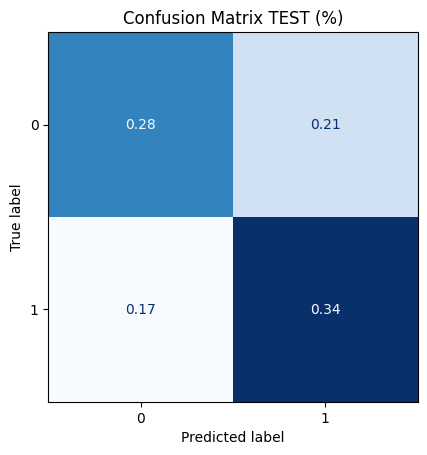

In [33]:
ConfusionMatrixDisplay(confusion_matrix=cm_test/len(y_test)).plot(colorbar = False, cmap = 'Blues')
plt.title('Confusion Matrix TEST (%)')
plt.plot()

- Accuracy, Precision, Recall y F1-Score

In [34]:
cm_test

array([[7320, 5310],
       [4474, 8668]])

In [35]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [36]:
print('Accuracy:', round( accuracy_score(y_test, y_test_pred),4))
print('Precision:', round( precision_score(y_test, y_test_pred), 4))
print('Recall:', round( recall_score(y_test, y_test_pred), 4))
print('F1-score:', round(f1_score(y_test, y_test_pred), 4))

Accuracy: 0.6204
Precision: 0.6201
Recall: 0.6596
F1-score: 0.6392


In [38]:
import shap

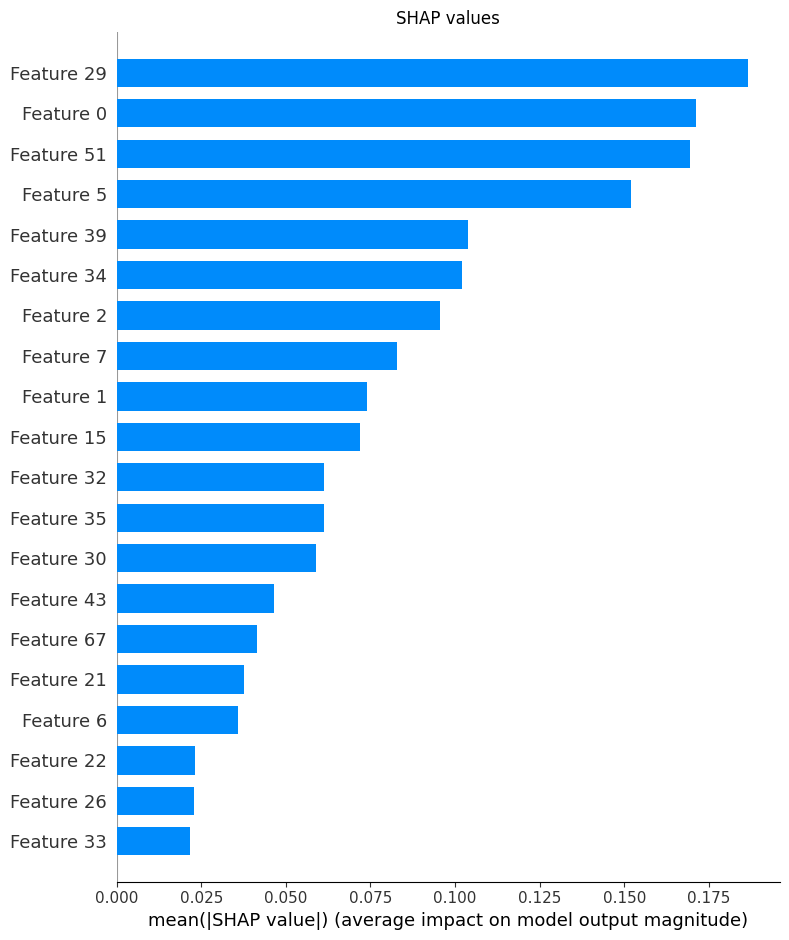

In [39]:
#SHAP value: peso en el output final
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
plt.title('SHAP values')
shap.summary_plot(shap_values, X_test, plot_type="bar", max_display=20)

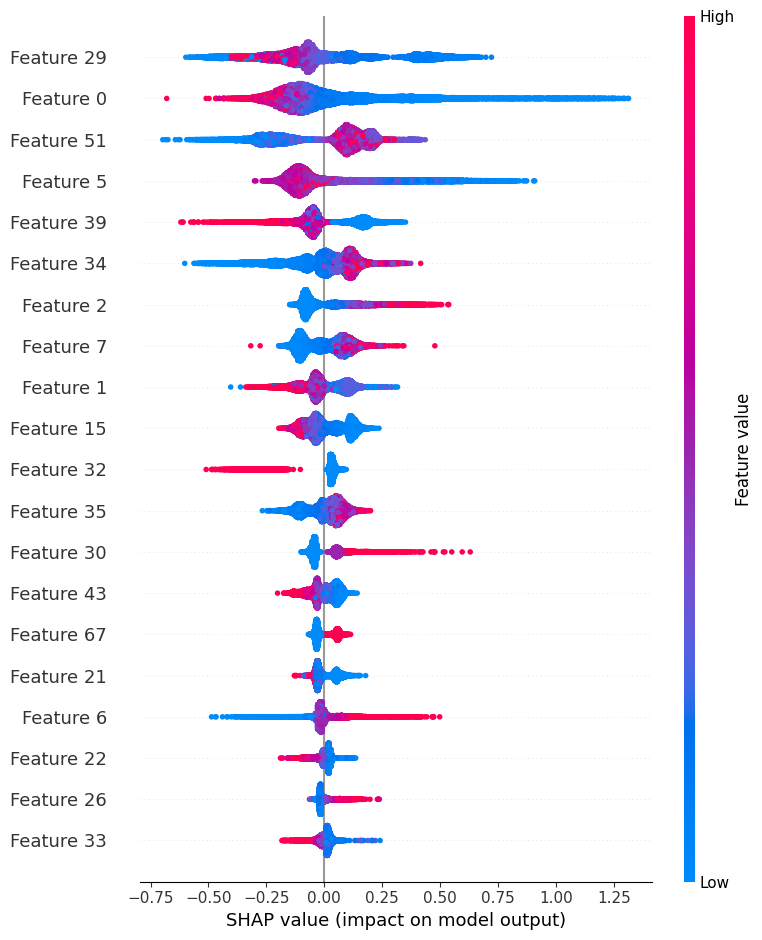

In [40]:
shap.summary_plot(shap_values, X_test)